In [1]:
import torch

In [5]:
#假复制-->真复制
x=torch.rand(3,4,5)
y=x.view(-1,20)
z=x.clone().view(-1,20)
x+=1
print(x,y,z)

tensor([[[1.0652, 1.3406, 1.0167, 1.6571, 1.1792],
         [1.0938, 1.2336, 1.2082, 1.3429, 1.4469],
         [1.9205, 1.7087, 1.8736, 1.6149, 1.0369],
         [1.1998, 1.5370, 1.9102, 1.0967, 1.9979]],

        [[1.3196, 1.4671, 1.4865, 1.6650, 1.1764],
         [1.2651, 1.2141, 1.7678, 1.7040, 1.2031],
         [1.5579, 1.4013, 1.2792, 1.3692, 1.5934],
         [1.6818, 1.3272, 1.0085, 1.5390, 1.0606]],

        [[1.4037, 1.5991, 1.0961, 1.7566, 1.2678],
         [1.7363, 1.1826, 1.3616, 1.3763, 1.4245],
         [1.3251, 1.7136, 1.6892, 1.0919, 1.6770],
         [1.3491, 1.0195, 1.1883, 1.9703, 1.0017]]]) tensor([[1.0652, 1.3406, 1.0167, 1.6571, 1.1792, 1.0938, 1.2336, 1.2082, 1.3429,
         1.4469, 1.9205, 1.7087, 1.8736, 1.6149, 1.0369, 1.1998, 1.5370, 1.9102,
         1.0967, 1.9979],
        [1.3196, 1.4671, 1.4865, 1.6650, 1.1764, 1.2651, 1.2141, 1.7678, 1.7040,
         1.2031, 1.5579, 1.4013, 1.2792, 1.3692, 1.5934, 1.6818, 1.3272, 1.0085,
         1.5390, 1.0606],
      

In [6]:
#标量tensor转常量
x=torch.randn(1)
print(x)
print(x.item())

tensor([-0.8825])
-0.8825053572654724


In [9]:
#内存开销减小
x=torch.randn(2,3)
y=torch.randn(2,3)
idbefore=id(y)
y=y+x
print(id(y)==idbefore)
x=torch.randn(2,3)
y=torch.randn(2,3)
idbefore=id(y)
y[:]=y+x
print(id(y)==idbefore)
x=torch.randn(2,3)
y=torch.randn(2,3)
idbefore=id(y)
torch.add(x,y,out=y)
print(id(y)==idbefore)

False
True
True


In [ ]:
#使用tensor.numpy()和torch.from_numpy()都会共享内存，而torch.tensor(numpy)不会


In [13]:
x = torch.tensor(1.0, requires_grad=True)
y1 = x ** 2
with torch.no_grad():
    y2 = x ** 3
y3 = y1 + y2
print(x.requires_grad)
print(y1, y1.requires_grad) # True
print(y2, y2.requires_grad) # False
print(y3, y3.requires_grad) # True

True
tensor(1., grad_fn=<PowBackward0>) True
tensor(1.) False
tensor(2., grad_fn=<AddBackward0>) True


In [15]:
#如果只需要修改tensor的数值，又不希望被autograd捕捉到，修改.data
x=torch.ones(1,requires_grad=True)
print(x.data)
print(x.data.requires_grad)
y=x*2
x.data*=100
y.backward()
print(x)
print(x.grad)

tensor([1.])
False
tensor([100.], requires_grad=True)
tensor([2.])


In [16]:
##################LinearRegression#######################

In [17]:
%matplotlib inline
import torch
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import random

In [18]:
num_inputs=2
num_examples=1000
true_w=[2,-3.4]
true_b=4.2
features=torch.from_numpy(np.random.normal(0,1,(num_examples,num_inputs)))
labels=true_w[0]*features[:,0]+true_w[1]*features[:,1]+true_b
labels+=torch.from_numpy(np.random.normal(0,0.01,size=labels.size()))

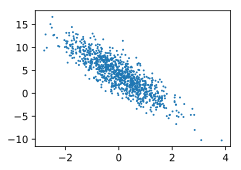

In [19]:
#生成散点图
def use_svg_display():
    display.set_matplotlib_formats('svg')
def set_figsize(figsize=(3.5,2.5)):
    use_svg_display()
    plt.rcParams['figure.figsize']=figsize
set_figsize()
plt.scatter(features[:,1].numpy(),labels.numpy(),1)

In [20]:
#定义函数返回批量
def data_iter(batch_size,features,labels):
    num_examples=len(features)
    indices=list(range(num_examples))
    random.shuffle(indices)
    for i in range(0,num_examples,batch_size):
        j=torch.LongTensor(indices[i:min(i+batch_size,num_examples)])
        #index_select通过index索引，0代表第0维
        yield features.index_select(0,j),labels.index_select(0,j)
        

In [27]:
#初始化模型参数
w=torch.tensor(np.random.normal(0,0.01,(num_inputs,1)),dtype=torch.double)
b=torch.zeros(1,dtype=torch.double)
w.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True)
#定义模型
def linear(X,w,b):
    return torch.mm(X,w)+b
#定义损失函数
def squared_loss(y_hat,y):
    return (y_hat-y.view(y_hat.size()))**2/2
#定义优化算法
def sgd(params,lr,batch_size):
    for param in params:
        #注意用的是.data
        param.data-=lr*param.grad/batch_size
#训练模型
lr=0.03
num_epochs=3
batch_size=10
net=linear
loss=squared_loss
for epoch in range(num_epochs):
    for X,y in data_iter(batch_size,features,labels):
        l=loss(net(X,w,b),y).sum()
        l.backward()
        sgd([w,b],lr,batch_size)
        w.grad.zero_()
        b.grad.zero_()
    train_l=loss(net(features,w,b),labels)
    print('epoch %d, loss %f' % (epoch + 1, train_l.mean().item()))

epoch 1, loss 0.046761
epoch 2, loss 0.000191
epoch 3, loss 0.000046


In [36]:
#LinearRegression的简洁实现
#定义数据
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
features = torch.tensor(np.random.normal(0, 1, (num_examples,
num_inputs)), dtype=torch.float)
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] +true_b
labels += torch.tensor(np.random.normal(0, 0.01,
size=labels.size()), dtype=torch.float)
#读取数据
import torch.utils.data as Data
batch_size=10
dataset=Data.TensorDataset(features,labels)
data_iter=Data.DataLoader(dataset,batch_size,shuffle=True)
#定义模型
from torch import nn
# class LinearNet(nn.Module):
#     def __init__(self,n_feature):
#         super(LinearNet, self).__init__()
#         self.linear=nn.Linear(n_feature,1)
#     def forward(self,x):
#         y=self.linear(x)
#         return y
# net=LinearNet(num_inputs)
# print(net)
# 写法⼀一
net = nn.Sequential(
nn.Linear(num_inputs, 1)
# 此处还可以传⼊入其他层
)
# # 写法⼆二
# net = nn.Sequential()
# net.add_module('linear', nn.Linear(num_inputs, 1))
# # net.add_module ......
# # 写法三
# from collections import OrderedDict
# net = nn.Sequential(OrderedDict([
# ('linear', nn.Linear(num_inputs, 1))
# # ......
# ]))
# print(net)
# print(net[0])
for param in net.parameters():
    print(param)
    
#初始化模型参数
from torch.nn import init
init.normal_(net[0].weight,mean=0,std=0.01)
init.constant_(net[0].bias,val=0)

#net[0].bias.data.fill_(0)
#损失函数
loss=nn.MSELoss()
#优化算法
import torch.optim as optim
optimizer=optim.SGD(net.parameters(),lr=0.03)
print(optimizer)
#可以为不同的子网络设置不同的学习率
# 调整学习率
for param_group in optimizer.param_groups:
    param_group['lr'] *= 0.1 # 学习率为之前的0.1倍
#训练模型
num_epochs = 3
for epoch in range(1, num_epochs + 1):
    for X, y in data_iter:
        output = net(X)
        l = loss(output, y.view(-1, 1))
        optimizer.zero_grad() # 梯度清零，等价于net.zero_grad()
        l.backward()
        optimizer.step()
print('epoch %d, loss: %f' % (epoch, l.item()))

Parameter containing:
tensor([[-0.5855,  0.3383]], requires_grad=True)
Parameter containing:
tensor([0.3793], requires_grad=True)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.03
    momentum: 0
    nesterov: False
    weight_decay: 0
)
epoch 3, loss: 0.649779


In [37]:
dense = net[0]
print(true_w, dense.weight)
print(true_b, dense.bias)

[2, -3.4] Parameter containing:
tensor([[ 1.6340, -2.9179]], requires_grad=True)
4.2 Parameter containing:
tensor([3.5760], requires_grad=True)
